In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/Gustav/miniconda3/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [9]:
data = pd.read_csv('/Users/Gustav/Downloads/311_Cases(01/05).csv') # , index_col=0
data

,Parcel(s),Building Name,Building Address,Postal Code,Floor Area,Category,Property Type - Self Selected,PIM Link,Year Built,Energy Audit Due Date,...,2014 Benchmark Status,2014 Reason for Exemption,2013 Benchmark Status,2013 Reason for Exemption,2012 Benchmark Status,2012 Reason for Exemption,2011 Benchmark Status,2011 Reason for Exemption,lat,lng
0,0010/001,2801 Leavenworth Street,2801 LEAVENWORTH ST,94109.0,133675.0,Commercial,Office,https://sfplanninggis.org/PIM/?tab=Property&se...,1907.0,04/01/2024,...,Complied,NaN,Complied,NaN,Complied,NaN,Complied,NaN,37.806973,-122.419034
1,0010/002,Argonaut Hotel-SV,495 JEFFERSON ST,94109.0,180000.0,Commercial,Hotel,https://sfplanninggis.org/PIM/?tab=Property&se...,1907.0,04/01/2025,...,Complied,NaN,Complied,NaN,Complied,NaN,Complied,NaN,37.807188,-122.420228
2,0011/007,Anchorage Square (2800 Leavenworth),2800 LEAVENWORTH ST,94133.0,485846.0,Commercial,Strip Mall,https://sfplanninggis.org/PIM/?tab=Property&se...,0.0,04/01/2024,...,Complied,NaN,Complied,NaN,Complied,NaN,Violation - Insufficient Data,NaN,37.806997,-122.418828
3,0011/008,Anchorage Garage,500 BEACH ST,94133.0,198525.0,Commercial,Strip Mall,https://sfplanninggis.org/PIM/?tab=Property&se...,1974.0,04/01/2024,...,Complied,NaN,Complied,NaN,Complied,NaN,Complied,NaN,37.807130,-122.417931
4,0012/001,211 Jefferson St,2739 TAYLOR ST,94133.0,40052.0,Commercial,Retail Store,https://sfplanninggis.org/PIM/?tab=Property&se...,1953.0,04/01/2025,...,Exempt,Tenant Turnover,Exempt,Tenant Turnover,Complied,NaN,Violation - Insufficient Data,NaN,37.807654,-122.415796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2553,9900/045-D,Pier 45 - Shed D,45 PIER - SHED D,94133.0,64628.0,Commercial - Port Facility,Other,https://sfplanninggis.org/PIM/?tab=Property&se...,1900.0,04/01/2099,...,Exempt,Added After Benchmark Year,Exempt,Added After Benchmark Year,Exempt,Added After Benchmark Year,NaN,NaN,0.000000,0.000000
2554,9900/048,Pier 48 - Shed A,48 PIER - SHED A,94158.0,83852.0,Commercial - Port Facility,Other,https://sfplanninggis.org/PIM/?tab=Property&se...,1900.0,04/01/2099,...,Complied,NaN,Complied,NaN,Complied,NaN,Complied,NaN,0.000000,0.000000
2555,9900/050,"Pier 50 - Shed A, B, and D",50 PIER,94158.0,108431.0,Commercial - Port Facility,Non-Refrigerated Warehouse,https://sfplanninggis.org/PIM/?tab=Property&se...,1900.0,04/01/2099,...,Complied,NaN,Violation - Did Not Report,NaN,Violation - Did Not Report,NaN,Violation - Did Not Report,NaN,44.659759,10.900125
2556,9900/050H,Pier 50 - Administration Building,401 Terry A Francois Blvd,94107.0,11701.0,Commercial - Port Facility,Office,https://sfplanninggis.org/PIM/?tab=Property&se...,NaN,04/01/2099,...,Exempt,Added After Benchmark Year,Exempt,Added After Benchmark Year,Exempt,Added After Benchmark Year,NaN,NaN,37.776472,-122.388327


# Data characteristics

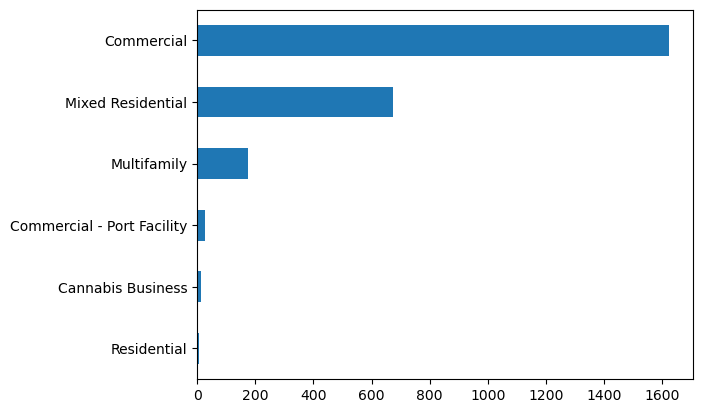

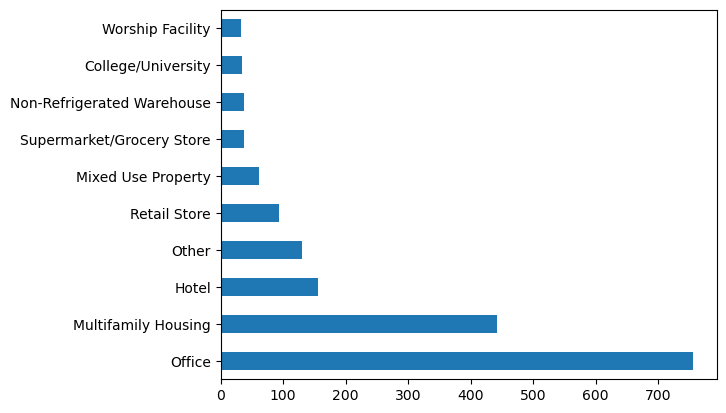

In [17]:
# only show top 10
data['Category'].value_counts().sort_values().plot(kind='barh')
plt.show()
data['Property Type - Self Selected'].value_counts().sort_values(ascending=False)[:10].plot(kind='barh')
plt.show()